In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
#have to change with different number of layers
def params_init():

  #np.random.seed(2)
  W1 = np.random.rand(200,784) - 0.5
  b1 = np.random.rand(200,1) - 0.5
  W2 = np.random.rand(50,200) - 0.5
  b2 = np.random.rand(50,1) - 0.5
  W3 = np.random.rand(10,50) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)


#have to change with different number of layers
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3


def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0


def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T


#have to change with different number of layers
def backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y):
  # print("Entered Backprop")
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ3 = (A3 - Y)
  print("BP \n ", dZ3)
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)

  dZ2 = np.matmul(W3.T, dZ3)*relu_d(Z2) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1


  return dW1, db1, dW2, db2, dW3, db3


#have to change with different number of layers
def param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))
  W3 = W3 - lr*dW3
  b3 = b3 - lr*(db3.reshape(b3.shape))
  #W4 = W4 - lr*dW4
  #b4 = b4 - lr*db4

  return W1, b1, W2, b2, W3, b3


#have to change with different number of layers
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  weightsDict["W1"] = W1
  weightsDict["b1"] = b1
  weightsDict["W2"] = W2
  weightsDict["b2"] = b2
  weightsDict["W3"] = W3
  weightsDict["b3"] = b3

  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights




def grad_descent(X,Y,iter, lr, print_op, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0
    X1, Y1 = X.T, Y
    X1 = X1.T #take transpose to match the sizes

    Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

    dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)

    W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights



def NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, X1, Y1):
  #calculating dw3 and db3
  #first approximate dZ3
  m = Z3.shape[1]
  lossArrayAfterPertZ3 = np.zeros_like(Z3)
  for i in range(Z3.shape[0]):
    Z3pert = Z3.copy() #creates a local copy of the array since python arrays are sent by reference andnot copy!!
    Z3pert[i] +=  pert
    A3pert = softmax(Z3pert)
    #print("Z3")
    lossArrayAfterPertZ3[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  
  dZ3 = (lossArrayAfterPertZ3 - lossBeforePert)/pert
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)


  #calculating the dZ2 and db2

  lossArrayAfterPertZ2 = np.zeros_like(Z2)

  for i in range(Z2.shape[0]):
    Z2pert = Z2.copy()
    Z2pert[i] += pert

    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    #print("Z2")
    lossArrayAfterPertZ2[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  
  dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  #calculating the dZ1 and db1
  lossArrayAfterPertZ1 = np.zeros_like(Z1)
  for i in range(Z1.shape[0]):
    Z1pert = Z1.copy()
    Z1pert[i] += pert

    A1pert = relu(Z1pert)

    Z2pert = np.matmul(W2,A1pert) + b2 
    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    #print("Z1")
    #print(f"sub sub in iter{i}")

    lossArrayAfterPertZ1[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert

  dW1 = 1/m*np.matmul(dZ1,X1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1

  return dW1, db1, dW2, db2, dW3, db3



def batchGDNP(X,Y,iter, lr, pert, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  weightsDict["W1"] = W1
  weightsDict["b1"] = b1
  weightsDict["W2"] = W2
  weightsDict["b2"] = b2
  weightsDict["W3"] = W3
  weightsDict["b3"] = b3

  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 
      print(f"Iter {i} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      dW1, db1, dW2, db2, dW3, db3 = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, X1, Y1)
      #print(f"iter in iter{j}")
      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)
      #print(W1)

    if (i+1)%(print_op) == 0:
      print(f'\nIteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights




def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100


In [6]:
epochsToTrain = 200

In [7]:
pertList = [1,0.1, 0.01, 0.001, 0.0001]
trainAccPertList = []
valAccPertList = []

In [8]:
W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights = batchGDNP(x_train,y_train,epochsToTrain, 0.1, 1, 1)

Params Initialised
Iter 0 -> sub iter 99 : 69.841269841269834
Iteration: 1
Train accuracy: 70.33809523809524
Val accuracy: 69.27142857142857
Iter 1 -> sub iter 99 : 79.68253968253968
Iteration: 2
Train accuracy: 79.0079365079365
Val accuracy: 78.08571428571427
Iter 2 -> sub iter 99 : 82.69841269841271
Iteration: 3
Train accuracy: 82.1079365079365
Val accuracy: 81.22857142857143
Iter 3 -> sub iter 99 : 84.28571428571429
Iteration: 4
Train accuracy: 84.05238095238096
Val accuracy: 83.52857142857142
Iter 4 -> sub iter 99 : 85.23809523809524
Iteration: 5
Train accuracy: 85.35396825396825
Val accuracy: 84.88571428571429
Iter 5 -> sub iter 99 : 86.82539682539682
Iteration: 6
Train accuracy: 86.41904761904762
Val accuracy: 85.97142857142858
Iter 6 -> sub iter 99 : 87.30158730158732
Iteration: 7
Train accuracy: 87.17777777777778
Val accuracy: 86.62857142857143
Iter 7 -> sub iter 99 : 88.09523809523809
Iteration: 8
Train accuracy: 87.86825396825397
Val accuracy: 87.41428571428571
Iter 8 -> sub 

In [10]:
for pert in pertList:
    print(f"Training for {pert}")
    W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights = batchGDNP(x_train,y_train,epochsToTrain, 0.01, pert, 1)
    trainAccPertList.append(train_acc)
    valAccPertList.append(val_acc)


Training for 1
Params Initialised
Iter 0 -> sub iter 99 : 23.333333333333332
Iteration: 1
Train accuracy: 21.192063492063493
Val accuracy: 21.185714285714287
Iter 1 -> sub iter 99 : 32.380952380952387
Iteration: 2
Train accuracy: 30.338095238095235
Val accuracy: 30.185714285714287
Iter 2 -> sub iter 99 : 39.365079365079374
Iteration: 3
Train accuracy: 36.630158730158726
Val accuracy: 35.885714285714286
Iter 3 -> sub iter 99 : 43.333333333333336
Iteration: 4
Train accuracy: 40.7015873015873
Val accuracy: 39.957142857142856
Iter 4 -> sub iter 99 : 45.873015873015874
Iteration: 5
Train accuracy: 43.32222222222222
Val accuracy: 43.042857142857144
Iter 5 -> sub iter 99 : 47.777777777777786
Iteration: 6
Train accuracy: 45.303174603174604
Val accuracy: 44.94285714285714
Iter 6 -> sub iter 99 : 49.365079365079376
Iteration: 7
Train accuracy: 48.33174603174603
Val accuracy: 47.3
Iter 7 -> sub iter 99 : 55.079365079365084
Iteration: 8
Train accuracy: 53.77301587301587
Val accuracy: 52.6714285714

In [7]:
W1, b1, W2, b2, W3, b3, train_acc_bp, val_acc_bp, train_loss_bp, val_loss_bp, sum_weights_bp = batch_grad_descent(x_train,y_train,epochsToTrain, 0.1,1)

Params Initialised
Iteration: 1
Train accuracy: 81.73650793650793
Val accuracy: 81.02857142857142
Iteration: 2
Train accuracy: 86.43174603174603
Val accuracy: 85.91428571428571
Iteration: 3
Train accuracy: 88.5984126984127
Val accuracy: 88.18571428571428
Iteration: 4
Train accuracy: 89.78571428571429
Val accuracy: 89.44285714285715
Iteration: 5
Train accuracy: 90.70158730158731
Val accuracy: 90.21428571428571
Iteration: 6
Train accuracy: 91.39206349206349
Val accuracy: 90.72857142857143
Iteration: 7
Train accuracy: 91.88730158730158
Val accuracy: 91.15714285714286
Iteration: 8
Train accuracy: 92.33650793650794
Val accuracy: 91.45714285714286
Iteration: 9
Train accuracy: 92.70793650793651
Val accuracy: 91.75714285714285
Iteration: 10
Train accuracy: 93.04126984126984
Val accuracy: 92.08571428571429
Iteration: 11
Train accuracy: 93.31746031746032
Val accuracy: 92.41428571428571
Iteration: 12
Train accuracy: 93.57460317460318
Val accuracy: 92.55714285714286
Iteration: 13
Train accuracy: 9

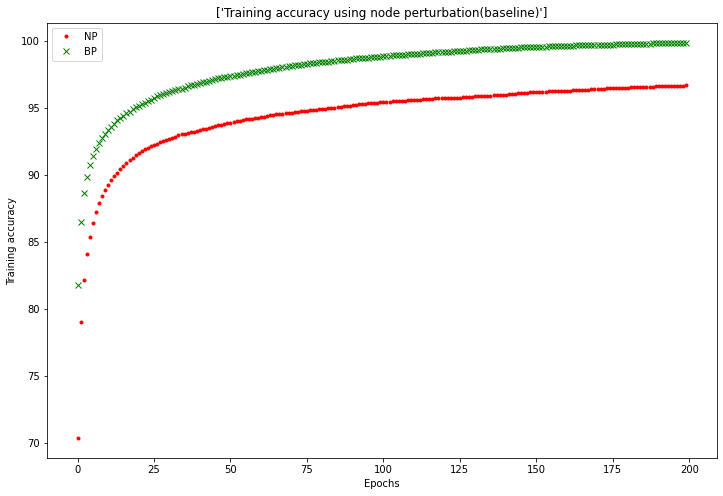

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, "r.")
plt.plot(train_acc_bp, "gx")
plt.title(["Training accuracy using node perturbation(baseline)"])
plt.xlabel("Epochs", size=10)
plt.ylabel("Training accuracy", size = 10)
plt.legend(["NP", "BP"])

# Imposing variability and seeing the effect of variability on the accuracy

In [7]:
mu = 0.7
sigma = 0.3
vDD = 5
precision = 10#setting the precision value of the calculations
wRange = 3
noOfLevels = 2**precision - 1 #no of levels of quantization
step = round(wRange/noOfLevels, precision) #step size of each of the step after quantization
discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps

In [8]:
def getVth(mu, sigma, shape):
  #last dimension represents the binary rep for each weight
  return np.random.normal(loc=mu, scale=sigma, size=shape) #each bit is represented by an sram so we need those many vth values for each mosfet in this set

In [9]:
def initMosParam(shape, mu, sigma, vDD, precision):
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)

    Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 

    iOn = ((vDD - Vth)**2)*1e-06#scaling the current according to Ioff values arbitraryfor now!!


    iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))


    iOff = np.random.uniform(low=0, high=1e-10, size = sizeI)#no negative value
    return (iOn, iOnNominal, iOff)

In [10]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray += np.sign(weightArray) * np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)



  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [11]:
#have to change with different number of layers
def params_init():

  #np.random.seed(2)
  W1 = np.random.rand(200,784) - 0.5
  b1 = np.random.rand(200,1) - 0.5
  W2 = np.random.rand(50,200) - 0.5
  b2 = np.random.rand(50,1) - 0.5
  W3 = np.random.rand(10,50) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)


#have to change with different number of layers
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3


def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0


def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T


#have to change with different number of layers
def backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y):
  # print("Entered Backprop")
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ3 = (A3 - Y)
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)

  dZ2 = np.matmul(W3.T, dZ3)*relu_d(Z2) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1


  return dW1, db1, dW2, db2, dW3, db3


#have to change with different number of layers
def param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))
  W3 = W3 - lr*dW3
  b3 = b3 - lr*(db3.reshape(b3.shape))
  #W4 = W4 - lr*dW4
  #b4 = b4 - lr*db4

  return W1, b1, W2, b2, W3, b3


#have to change with different number of layers
def batch_grad_descentFPOCBP(X,Y,iter, lr, mu, sigma, vDD, precision, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  W1Currents = initMosParam((200, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((200, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((50, 1), mu, sigma, vDD, precision)
  W3Currents = initMosParam((10, 50),mu, sigma, vDD, precision)
  b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes 

      startin = time.time()
      W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps)
      b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps)
      W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps)
      b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps)
      W3varoc = weightTransformWithVariability(W3, W3Currents, precision, step, discreteSteps)
      b3varoc = weightTransformWithVariability(b3, b3Currents, precision, step, discreteSteps)
      endin = time.time()
      #print(f"#Fin processing weights {endin-startin}                                                     ", end = "\r", flush= True)


      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights



def NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, X1, Y1):
  #calculating dw3 and db3
  #first approximate dZ3
  m = Z3.shape[1]
  lossArrayAfterPertZ3 = np.zeros_like(Z3)
  for i in range(Z3.shape[0]):
    Z3pert = Z3.copy() #creates a local copy of the array since python arrays are sent by reference andnot copy!!
    Z3pert[i] +=  pert
    A3pert = softmax(Z3pert)
    #print("Z3")
    lossArrayAfterPertZ3[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  
  dZ3 = (lossArrayAfterPertZ3 - lossBeforePert)/pert
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)


  #calculating the dZ2 and db2

  lossArrayAfterPertZ2 = np.zeros_like(Z2)

  for i in range(Z2.shape[0]):
    Z2pert = Z2.copy()
    Z2pert[i] += pert

    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    #print("Z2")
    lossArrayAfterPertZ2[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  
  dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  #calculating the dZ1 and db1
  lossArrayAfterPertZ1 = np.zeros_like(Z1)
  for i in range(Z1.shape[0]):
    Z1pert = Z1.copy()
    Z1pert[i] += pert

    A1pert = relu(Z1pert)

    Z2pert = np.matmul(W2,A1pert) + b2 
    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    print("Z1")
    print(f"sub sub in iter{i}")

    lossArrayAfterPertZ1[i] = np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert

  dW1 = 1/m*np.matmul(dZ1,X1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1

  return dW1, db1, dW2, db2, dW3, db3





def batch_grad_descentFPOCNP(X,Y,iter, lr, pert, mu, sigma, vDD, precision, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  W1Currents = initMosParam((200, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((200, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((50, 1), mu, sigma, vDD, precision)
  W3Currents = initMosParam((10, 50),mu, sigma, vDD, precision)
  b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes 

      #startin = time.time()
      W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps)
      b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps)
      W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps)
      b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps)
      W3varoc = weightTransformWithVariability(W3, W3Currents, precision, step, discreteSteps)
      b3varoc = weightTransformWithVariability(b3, b3Currents, precision, step, discreteSteps)
      #endin = time.time()
      #print(f"#Fin processing weights {endin-startin}                                                     ", end = "\r", flush= True)


      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc) 

      print(f"Iter {i} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      dW1, db1, dW2, db2, dW3, db3 = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, X1, Y1)
      


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)

    if (i+1)%(print_op) == 0:
      #print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      #print(f'Val accuracy: {val_score}')

      print(f"Iteration: {i + 1}::Train accuracy: {train_score}::Val accuracy: {val_score}::Train loss {1/63000*np.sum((A3_train-one_hot_encoding(Y))**2)}::Val Loss {1/63000*np.sum((A3_val-one_hot_encoding(y_val))**2)}")

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights







def grad_descent(X,Y,iter, lr, print_op, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0
    X1, Y1 = X.T, Y
    X1 = X1.T #take transpose to match the sizes

    Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

    dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)

    W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights


def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/Y.shape[0]*100


In [12]:
def batch_grad_descentOCBP(X,Y,iter, lr, mu, sigma, vDD, precision, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  W1Currents = initMosParam((200, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((200, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((50, 1), mu, sigma, vDD, precision)
  W3Currents = initMosParam((10, 50),mu, sigma, vDD, precision)
  b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)


  dW1Currents = initMosParam((200, 784), mu, sigma, vDD, precision)
  db1Currents = initMosParam((200, 1), mu, sigma, vDD, precision)
  dW2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision)
  db2Currents = initMosParam((50, 1), mu, sigma, vDD, precision)
  dW3Currents = initMosParam((10, 50),mu, sigma, vDD, precision)
  db3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes 

      #startin = time.time()
      W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps)
      b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps)
      W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps)
      b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps)
      W3varoc = weightTransformWithVariability(W3, W3Currents, precision, step, discreteSteps)
      b3varoc = weightTransformWithVariability(b3, b3Currents, precision, step, discreteSteps)
      #endin = time.time()
      #print(f"#Fin processing weights {endin-startin}                                                     ", end = "\r", flush= True)


      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1varoc, W2varoc, W3varoc, X1, Y1)

      dW1varoc = weightTransformWithVariability(dW1, dW1Currents, precision, step, discreteSteps)
      db1varoc = weightTransformWithVariability(db1.reshape(db1.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varoc = weightTransformWithVariability(dW2, dW2Currents, precision, step, discreteSteps)
      db2varoc = weightTransformWithVariability(db2.reshape(db2.shape[0],1), db2Currents, precision, step, discreteSteps)
      dW3varoc = weightTransformWithVariability(dW3, dW3Currents, precision, step, discreteSteps)
      db3varoc = weightTransformWithVariability(db3.reshape(db3.shape[0],1), db3Currents, precision, step, discreteSteps)


      W1, b1, W2, b2, W3, b3 = param_update(W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc, dW1varoc, db1varoc, dW2varoc, db2varoc, dW3varoc, db3varoc, lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights

In [13]:
def batch_grad_descentOCNP(X,Y,iter, lr, pert, mu, sigma, vDD, precision, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  W1Currents = initMosParam((200, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((200, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((50, 1), mu, sigma, vDD, precision)
  W3Currents = initMosParam((10, 50),mu, sigma, vDD, precision)
  b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)




  dW1Currents = initMosParam((200, 784), mu, sigma, vDD, precision)
  db1Currents = initMosParam((200, 1), mu, sigma, vDD, precision)
  dW2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision)
  db2Currents = initMosParam((50, 1), mu, sigma, vDD, precision)
  dW3Currents = initMosParam((10, 50),mu, sigma, vDD, precision)
  db3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)
  

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes 

      #startin = time.time()
      W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps)
      b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps)
      W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps)
      b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps)
      W3varoc = weightTransformWithVariability(W3, W3Currents, precision, step, discreteSteps)
      b3varoc = weightTransformWithVariability(b3, b3Currents, precision, step, discreteSteps)
      #endin = time.time()
      #print(f"#Fin processing weights {endin-startin}                                                     ", end = "\r", flush= True)


      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc) 
      #print(np.min(np.abs(W1)), np.min(np.abs(b1)), np.min(np.abs(W2)), np.min(np.abs(b2)), np.min(np.abs(W3)), np.min(np.abs(b3)))

      print(f"Iter {i} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      dW1, db1, dW2, db2, dW3, db3 = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varoc, W2varoc, W3varoc, b1varoc, b2varoc, b3varoc, X1, Y1)
      #print(db1.shape)

      dW1varoc = weightTransformWithVariability(dW1, dW1Currents, precision, step, discreteSteps)
      db1varoc = weightTransformWithVariability(db1.reshape(db1.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varoc = weightTransformWithVariability(dW2, dW2Currents, precision, step, discreteSteps)
      db2varoc = weightTransformWithVariability(db2.reshape(db2.shape[0],1), db2Currents, precision, step, discreteSteps)
      dW3varoc = weightTransformWithVariability(dW3, dW3Currents, precision, step, discreteSteps)
      db3varoc = weightTransformWithVariability(db3.reshape(db3.shape[0],1), db3Currents, precision, step, discreteSteps)
      #print(dW3)




      #W1, b1, W2, b2, W3, b3 = param_update(W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc, dW1varoc, db1varoc, dW2varoc, db2varoc, dW3varoc, db3varoc, lr = lr)

      W1, b1, W2, b2, W3, b3 = param_update(W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc, dW1, db1, dW2, db2, dW3, db3, lr = lr)


    if (i+1)%(print_op) == 0:
      #print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      #print(f'Val accuracy: {val_score}')

      print(f"Iteration: {i + 1}::Train accuracy: {train_score}::Val accuracy: {val_score}::Train loss {1/63000*np.sum((A3_train-one_hot_encoding(Y))**2)}::Val Loss {1/63000*np.sum((A3_val-one_hot_encoding(y_val))**2)}")

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights

# Plotting the effect of variability on the final accuracies

In [144]:
finalTrainAcc = []
finalValAcc = []
sigmaList = [0.1, 0.01, 0.001, 0.0001]

In [146]:
for sigma in sigmaList:
    W1, b1, W2, b2, W3, b3, train_acc_bpVar, val_acc_bpVar, train_loss_bpVar, val_loss_bpVar, sum_weights_bpVar = batch_grad_descentOCBP(x_train,y_train,100 , 0.0005, mu,sigma, vDD, precision, print_op=1)
    finalTrainAcc.append(train_acc_bpVar[-1])
    finalValAcc.append(val_acc_bpVar[-1])

Params Initialised
Iteration: 1
Train accuracy: 12.15079365079365
Val accuracy: 11.928571428571429
Iteration: 2
Train accuracy: 12.376190476190477
Val accuracy: 12.828571428571427
Iteration: 3
Train accuracy: 12.617460317460317
Val accuracy: 12.9
Iteration: 4
Train accuracy: 12.536507936507938
Val accuracy: 12.3


KeyboardInterrupt: 

In [ ]:
plt.plot(finalTrainAcc)

In [16]:
W1, b1, W2, b2, W3, b3, train_acc_npVarAll, val_acc_npVarAll, train_loss_npVarAll, val_loss_npVarAll, sum_weights_npVarAll = batch_grad_descentOCNP(X=x_train,Y=y_train,iter = epochsToTrain, lr=0.5, pert=0.0001, mu=mu, sigma=0.1, vDD = vDD, precision = precision, print_op=1)

Params Initialised
Iteration: 1::Train accuracy: 48.65238095238095::Val accuracy: 47.65714285714286::Train loss 1.0125491483283615::Val Loss 0.11469425632050993


KeyboardInterrupt: 

In [45]:
W1, b1, W2, b2, W3, b3, train_acc_npVar, val_acc_npVar, train_loss_npVar, val_loss_npVar, sum_weights_npVar = batch_grad_descentFPOCNP(X=x_train,Y=y_train,iter = epochsToTrain, lr=0.005, pert=0.5, mu=mu, sigma=sigma, vDD = vDD, precision = precision, print_op=1)

Params Initialised
Iteration: 1::Train accuracy: 13.200000000000001::Val accuracy: 13.314285714285715::Train loss 1.566857139916198::Val Loss 0.17345653254052462
Iteration: 2::Train accuracy: 21.284126984126985::Val accuracy: 21.37142857142857::Train loss 1.4363407935332517::Val Loss 0.1594937005890703
Iteration: 3::Train accuracy: 25.63015873015873::Val accuracy: 25.142857142857146::Train loss 1.3699294923959326::Val Loss 0.15311371716078398
Iteration: 4::Train accuracy: 28.40793650793651::Val accuracy: 27.885714285714286::Train loss 1.3242668092887602::Val Loss 0.1484728716058764
Iteration: 5::Train accuracy: 30.631746031746033::Val accuracy: 30.028571428571425::Train loss 1.2878223717344564::Val Loss 0.1446851014398137
Iteration: 6::Train accuracy: 32.05396825396825::Val accuracy: 31.2::Train loss 1.263716840929155::Val Loss 0.1423615132114519
Iteration: 7::Train accuracy: 33.46825396825397::Val accuracy: 32.471428571428575::Train loss 1.2398404015421536::Val Loss 0.1398367348754305

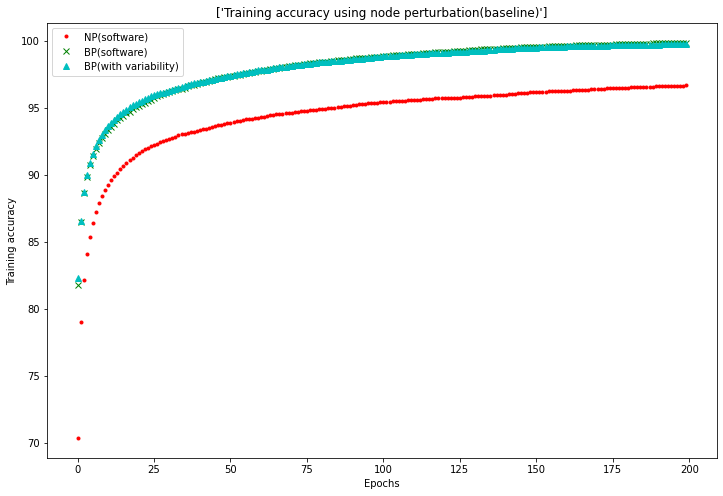

In [41]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, "r.")
plt.plot(train_acc_bp, "gx")
plt.plot(train_acc_bpVar, "c^")
plt.title(["Training accuracy using node perturbation(baseline)"])
plt.xlabel("Epochs", size=10)
plt.ylabel("Training accuracy", size = 10)
plt.legend(["NP(software)", "BP(software)", "BP(with variability)"])

In [34]:
train_acc_bpVar[-1]

99.5873015873016

# Comparing the software NP and BP algorithms

In [14]:
def NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, X1, Y1):
  #calculating dw3 and db3
  #first approximate dZ3
  m = Z3.shape[1]
  #print(Z3.shape)
  lossArrayAfterPertZ3 = np.zeros_like(Z3)
  for i in range(Z3.shape[0]):
    Z3pert = Z3.copy() #creates a local copy of the array since python arrays are sent by reference andnot copy!!
    Z3pert[i, :] +=  pert
    A3pert = softmax(Z3pert)
    lossArrayAfterPertZ3[i, :] += np.sum(np.square(A3pert-one_hot_encoding(Y1)), axis=0)


  dZ3 = (lossArrayAfterPertZ3 - lossBeforePert)/pert

  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)


  #calculating the dZ2 and db2

  lossArrayAfterPertZ2 = np.zeros_like(Z2)

  for i in range(Z2.shape[0]):
    Z2pert = Z2.copy()
    Z2pert[i] += pert

    A2pert = relu(Z2pert)
    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    lossArrayAfterPertZ2[i,:] += np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

  
  dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  #calculating the dZ1 and db1
  lossArrayAfterPertZ1 = np.zeros_like(Z1)
  for i in range(Z1.shape[0]):
    Z1pert = Z1.copy()
    Z1pert[i] += pert
    A1pert = relu(Z1pert)
    Z2pert = np.matmul(W2,A1pert) + b2 
    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    
    lossArrayAfterPertZ1[i,:] += np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)

    
  #print(lossArrayAfterPertZ1)
  dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert

  dW1 = 1/m*np.matmul(dZ1,X1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1

  return dW1, db1, dW2, db2, dW3, db3

In [15]:
def batchGDComp(X,Y,iter, lrBP, lrNP, pert, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []

  W1, b1, W2, b2, W3, b3 = params_init()

  W1bp, b1bp, W2bp, b2bp, W3bp, b3bp = W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()

  W1np, b1np, W2np, b2np, W3np, b3np = W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    print(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes


      #doing the node perturbation pass first
      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1np, b1np, W2np,b2np, W3np, b3np) 
      print(f"NP Iter {i} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1np, W2np, W3np, b1np, b2np, b3np, X1, Y1)
      #print(f"iter in iter{j}")
      W1np, b1np, W2np, b2np, W3np, b3np = param_update(W1np, b1np, W2np, b2np, W3np, b3np, dW1np, db1np, dW2np, db2np, dW3np, db3np, lr = lrNP)
      #print(W1)



      #doing the back propagation for the same data set sample
      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1bp, b1bp, W2bp,b2bp, W3bp, b3bp) 
      print(f"                                                                        BP Iter {i} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      #print(f"Main iter: {i} Sub iter : {j}\n")
      dW1bp, db1bp, dW2bp, db2bp, dW3bp, db3bp = backprop(Z1, A1, Z2, A2, Z3, A3, W1bp, W2bp, W3bp, X1, Y1)
      #print(f"iter in iter{j}")
      W1bp, b1bp, W2bp, b2bp, W3bp, b3bp = param_update(W1bp, b1bp, W2bp, b2bp, W3bp, b3bp, dW1bp, db1bp, dW2bp, db2bp, dW3bp, db3bp, lr = lrBP)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()


    lrNP = lrNP*np.exp(-0.01)
    lrBP = lrBP*np.exp(-0.01)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1np, b1np, W2np, b2np, W3np, b3np)
      _, _, _, _, _, A3_train_bp = forward(X, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append([accuracy(predictions(A3_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1np, b1np, W2np, b2np, W3np, b3np)
      _, _, _, _, _,  A3_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append([accuracy(predictions(A3_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {train_score}::Val accuracy: {val_score}::Train Acc BP::{accuracy(predictions(A3_train_bp), Y)} Val Acc BP::{accuracy(predictions(A3_val_bp), y_val)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return w1Sim, b1Sim, w2Sim, b2Sim, w3Sim, b3Sim, train_acc, val_acc, train_loss, val_loss, sum_weights

In [88]:
w1Sim, b1Sim, w2Sim, b2Sim, w3Sim, b3Sim, trainAccBoth, valAccBoth, _, _, _ = batchGDComp(x_train,y_train,20, 0.1, 0.5, 1, print_op=1)

Params Initialised
0.9999999999999999
Iteration: 1::Train accuracy: 83.86825396825397::Val accuracy: 84.01428571428572::Train Acc BP::78.87777777777778 Val Acc BP::79.05714285714286
0.9995836635382563
Iteration: 2::Train accuracy: 88.56825396825397::Val accuracy: 88.3::Train Acc BP::84.95238095238096 Val Acc BP::84.95714285714286
0.9990861305443578
Iteration: 3::Train accuracy: 90.18571428571428::Val accuracy: 89.78571428571429::Train Acc BP::87.54444444444445 Val Acc BP::87.58571428571429
0.9986414556035522
Iteration: 4::Train accuracy: 91.25238095238095::Val accuracy: 90.8::Train Acc BP::89.02857142857142 Val Acc BP::89.0
0.9982375986346534
Iteration: 5::Train accuracy: 91.9968253968254::Val accuracy: 91.48571428571428::Train Acc BP::90.14285714285715 Val Acc BP::89.97142857142858
0.9978611626408245
Iteration: 6::Train accuracy: 92.57936507936509::Val accuracy: 91.74285714285715::Train Acc BP::90.94761904761904 Val Acc BP::90.55714285714286
0.9975004704632473
Iteration: 7::Train accu

In [16]:
perturbation = [0.0000000000000001, 0.000001, 0.01, 1]
trainBPList = []
trainNPList = []
for pert in perturbation:
    w1Sim, b1Sim, w2Sim, b2Sim, w3Sim, b3Sim, trainAccBoth, valAccBoth, _, _, _ = batchGDComp(x_train,y_train,20, 0.1, 0.1,pert, print_op=1)
    trainBPTemp= [i[0] for i in trainAccBoth]
    trainNPTemp = [i[1] for i in trainAccBoth]
    trainBPList.append(trainBPTemp)
    trainNPList.append(trainNPTemp)


Params Initialised
1.0
Iteration: 1::Train accuracy: 25.349206349206348::Val accuracy: 26.071428571428573::Train Acc BP::80.46031746031747 Val Acc BP::80.07142857142857
0.9994119482902641
Iteration: 2::Train accuracy: 29.06190476190476::Val accuracy: 29.85714285714286::Train Acc BP::86.41111111111111 Val Acc BP::85.8
0.998970464425642
Iteration: 3::Train accuracy: 31.482539682539684::Val accuracy: 32.4::Train Acc BP::88.71587301587302 Val Acc BP::88.1
0.9985511396217523
Iteration: 4::Train accuracy: 32.90793650793651::Val accuracy: 33.52857142857143::Train Acc BP::90.0936507936508 Val Acc BP::89.44285714285715
0.9981614170185603
Iteration: 5::Train accuracy: 32.695238095238096::Val accuracy: 33.91428571428571::Train Acc BP::91.02222222222223 Val Acc BP::90.02857142857142
0.9978258245114084
Iteration: 6::Train accuracy: 36.75873015873016::Val accuracy: 37.885714285714286::Train Acc BP::91.68571428571428 Val Acc BP::90.68571428571428
0.9974571636282409
Iteration: 7::Train accuracy: 38.79

Text(0, 0.5, 'Accuracy as % ->')

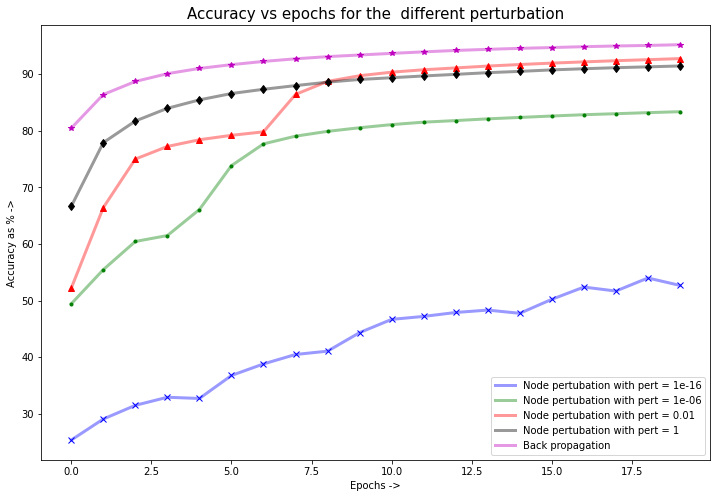

In [24]:
format = ['bx', 'g.', 'r^', 'kd']
col = ['b', 'g', 'r', 'k']
leg = []
plt.figure(figsize=(12,8))
for _ in range(len(perturbation)):
    plt.plot(trainNPList[_], col[_], linewidth=3,alpha=0.4)
plt.plot(trainBPList[0], 'm', linewidth=3,alpha=0.4)
for _ in range(len(perturbation)):
    leg.append(f"Node pertubation with pert = {perturbation[_]}")
    plt.plot(trainNPList[_], format[_])
    #plt.plot(trainNPList[_], col[_], linewidth=5,alpha=0.3)
plt.plot(trainBPList[0], 'm*')
leg.append("Back propagation")
plt.legend(leg)

plt.title("Accuracy vs epochs for the  different perturbation", size=15)
plt.xlabel("Epochs ->", size=10)
plt.ylabel("Accuracy as % ->", size = 10)

Text(0, 0.5, 'Accuracy as % ->')

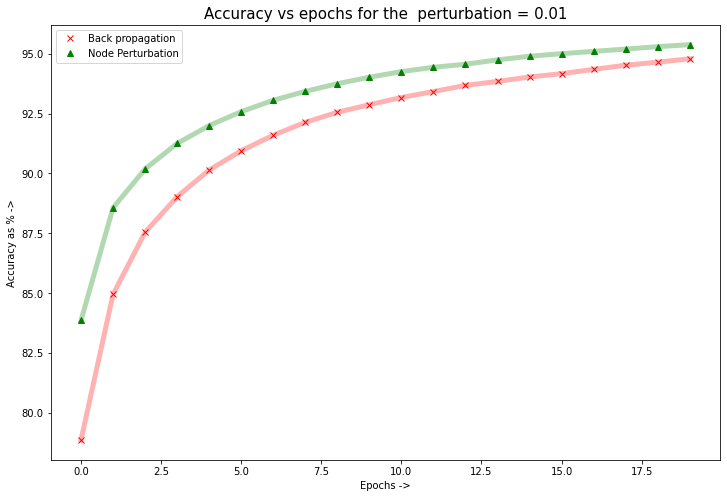

In [89]:
trainBP3= [i[0] for i in trainAccBoth]
trainNP3 = [i[1] for i in trainAccBoth]
plt.figure(figsize=(12,8))
plt.plot(trainBP3, 'rx')
plt.plot(trainNP3, 'g^')
plt.plot(trainBP3, 'r', linewidth=5,alpha=0.3)
plt.plot(trainNP3, 'g', linewidth=5,alpha=0.3)
plt.legend(["Back propagation", "Node Perturbation"])
plt.title("Accuracy vs epochs for the  perturbation = 0.01", size=15)
plt.xlabel("Epochs ->", size=10)
plt.ylabel("Accuracy as % ->", size = 10)

In [104]:
w1Sim, b1Sim, w2Sim, b2Sim, w3Sim, b3Sim, trainAccBoth, valAccBoth, _, _, _ = batchGDComp(x_train,y_train,100, 0.0001, 0.000005, print_op=1)

Params Initialised
0.9999999999999997
Iteration: 1::Train accuracy: 9.846031746031745::Val accuracy: 9.971428571428572::Train Acc BP::9.844444444444445 Val Acc BP::9.185714285714287
0.9999995164409428
Iteration: 2::Train accuracy: 9.974603174603175::Val accuracy: 10.085714285714285::Train Acc BP::11.007936507936508 Val Acc BP::10.4
0.9999985844600019
Iteration: 3::Train accuracy: 10.096825396825396::Val accuracy: 10.4::Train Acc BP::12.304761904761904 Val Acc BP::11.942857142857143
0.9999975219493955
Iteration: 4::Train accuracy: 10.217460317460317::Val accuracy: 10.585714285714285::Train Acc BP::13.561904761904762 Val Acc BP::13.385714285714286
0.9999965073297103
Iteration: 5::Train accuracy: 10.353968253968254::Val accuracy: 10.557142857142857::Train Acc BP::14.844444444444443 Val Acc BP::14.657142857142858
0.9999955591551105
Iteration: 6::Train accuracy: 10.47936507936508::Val accuracy: 10.614285714285714::Train Acc BP::15.946031746031746 Val Acc BP::15.814285714285713
0.99999464490

Text(0, 0.5, 'Accuracy as % ->')

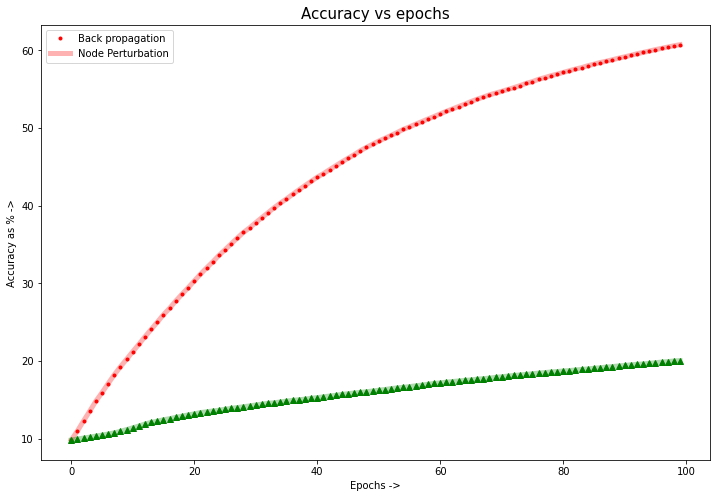

In [118]:
trainBP = [i[0] for i in trainAccBoth]
trainNP = [i[1] for i in trainAccBoth]
plt.figure(figsize=(12,8))
plt.plot(trainBP, 'r.')
plt.plot(trainBP, 'r', linewidth=5,alpha=0.3)
plt.plot(trainNP, 'g^')
plt.plot(trainNP, 'g', linewidth=5,alpha=0.3)
plt.legend(["Back propagation", "Node Perturbation"])
plt.title("Accuracy vs epochs", size=15)
plt.xlabel("Epochs ->", size=10)
plt.ylabel("Accuracy as % ->", size = 10)

Text(0, 0.5, 'Cosine Similiarity of the NP and BP updates')

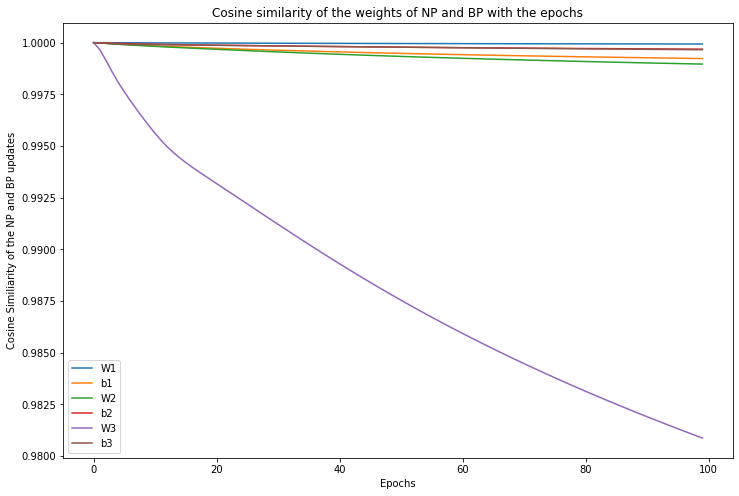

In [113]:
plt.figure(figsize=(12,8))
plt.plot(w1Sim)
plt.plot(b1Sim)
plt.plot(w2Sim)
plt.plot(b2Sim)
plt.plot(w3Sim)
plt.plot(b3Sim)
plt.legend(["W1", "b1", "W2", "b2", "W3", "b3"])
plt.title("Cosine similarity of the weights of NP and BP with the epochs")
plt.xlabel("Epochs")
plt.ylabel("Cosine Similiarity of the NP and BP updates")

# Comparing the performance of BP and NP with the full variability play

In [17]:
#have to change with different number of layers
def params_init():

  #np.random.seed(2)
  W1 = np.random.rand(200,784) - 0.5
  b1 = np.random.rand(200,1) - 0.5
  W2 = np.random.rand(50,200) - 0.5
  b2 = np.random.rand(50,1) - 0.5
  W3 = np.random.rand(10,50) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)

In [18]:
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)
  #print("b3 shape = ",b3.shape, " A2fp shape = ", A2.shape," and W3 shape = ", W3.shape)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3

In [19]:
def batchGDCompOC(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, discreteSteps, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []

  W1, b1, W2, b2, W3, b3 = params_init()

  W1bp, b1bp, W2bp, b2bp, W3bp, b3bp = W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()

  W1np, b1np, W2np, b2np, W3np, b3np = W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()


  W1Currents = initMosParam((200, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((200, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((50, 1), mu, sigma, vDD, precision)
  W3Currents = initMosParam((10, 50),mu, sigma, vDD, precision)
  b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)




  dW1Currents = initMosParam((200, 784), mu, sigma, vDD, precision)
  db1Currents = initMosParam((200, 1), mu, sigma, vDD, precision)
  dW2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision)
  db2Currents = initMosParam((50, 1), mu, sigma, vDD, precision)
  dW3Currents = initMosParam((10, 50),mu, sigma, vDD, precision)
  db3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    print(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      W1varocnp = weightTransformWithVariability(W1np, W1Currents, precision, step, discreteSteps)
      b1varocnp = weightTransformWithVariability(b1np, b1Currents, precision, step, discreteSteps)
      W2varocnp = weightTransformWithVariability(W2np, W2Currents, precision, step, discreteSteps)
      b2varocnp = weightTransformWithVariability(b2np, b2Currents, precision, step, discreteSteps)
      W3varocnp = weightTransformWithVariability(W3np, W3Currents, precision, step, discreteSteps)
      b3varocnp = weightTransformWithVariability(b3np, b3Currents, precision, step, discreteSteps)

      #print(W3varocnp.shape)
      #doing the node perturbation pass first
      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varocnp, b1varocnp, W2varocnp,b2varocnp, W3varocnp, b3varocnp) 
      print(f"NP Iter {i} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varocnp, W2varocnp, W3varocnp,b1varocnp, b2varocnp, b3varocnp, X1, Y1)
      #print(f"iter in iter{j}")


      dW1varocnp = weightTransformWithVariability(dW1np, dW1Currents, precision, step, discreteSteps)
      db1varocnp = weightTransformWithVariability(db1np.reshape(db1np.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varocnp = weightTransformWithVariability(dW2np, dW2Currents, precision, step, discreteSteps)
      db2varocnp = weightTransformWithVariability(db2np.reshape(db2np.shape[0],1), db2Currents, precision, step, discreteSteps)
      dW3varocnp = weightTransformWithVariability(dW3np, dW3Currents, precision, step, discreteSteps)
      db3varocnp = weightTransformWithVariability(db3np.reshape(db3np.shape[0],1), db3Currents, precision, step, discreteSteps)



      W1np, b1np, W2np, b2np, W3np, b3np = param_update(W1varocnp, b1varocnp, W2varocnp,b2varocnp, W3varocnp, b3varocnp, dW1varocnp, db1varocnp, dW2varocnp, db2varocnp, dW3varocnp, db3varocnp, lr = lrNP)
      #print(W1)



      #doing the back propagation for the same data set sample

      W1varocbp = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps)
      b1varocbp = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps)
      W2varocbp = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps)
      b2varocbp = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps)
      W3varocbp = weightTransformWithVariability(W3bp, W3Currents, precision, step, discreteSteps)
      b3varocbp = weightTransformWithVariability(b3bp, b3Currents, precision, step, discreteSteps)

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varocbp, b1varocbp, W2varocbp,b2varocbp, W3varocbp, b3varocbp) 
      print(f"                                                                        BP Iter {i} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      #print(f"Main iter: {i} Sub iter : {j}\n")
      dW1bp, db1bp, dW2bp, db2bp, dW3bp, db3bp = backprop(Z1, A1, Z2, A2, Z3, A3, W1varocbp, W2varocbp, W3varocbp, X1, Y1)
      #print(f"iter in iter{j}")


      dW1varocbp = weightTransformWithVariability(dW1bp, dW1Currents, precision, step, discreteSteps)
      db1varocbp = weightTransformWithVariability(db1bp.reshape(db1bp.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varocbp = weightTransformWithVariability(dW2bp, dW2Currents, precision, step, discreteSteps)
      db2varocbp = weightTransformWithVariability(db2bp.reshape(db2bp.shape[0],1), db2Currents, precision, step, discreteSteps)
      dW3varocbp = weightTransformWithVariability(dW3bp, dW3Currents, precision, step, discreteSteps)
      db3varocbp = weightTransformWithVariability(db3bp.reshape(db3bp.shape[0],1), db3Currents, precision, step, discreteSteps)


      W1bp, b1bp, W2bp, b2bp, W3bp, b3bp = param_update(W1varocbp, b1varocbp, W2varocbp, b2varocbp, W3varocbp, b3varocbp, dW1varocbp, db1varocbp, dW2varocbp, db2varocbp, dW3varocbp, db3varocbp, lr = lrBP)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()


    #lrNP = lrNP*np.exp(-0.1)
    #lrBP = lrBP*np.exp(-0.1)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1np, b1np, W2np, b2np, W3np, b3np)
      _, _, _, _, _, A3_train_bp = forward(X, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append([accuracy(predictions(A3_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1np, b1np, W2np, b2np, W3np, b3np)
      _, _, _, _, _,  A3_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append([accuracy(predictions(A3_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}::Train Acc BP::{round(accuracy(predictions(A3_train_bp), Y), 3)} Val Acc BP::{round(accuracy(predictions(A3_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return w1Sim, b1Sim, w2Sim, b2Sim, w3Sim, b3Sim, train_acc, val_acc, train_loss, val_loss, sum_weights

In [76]:
iter=10
lrBP=0.01
lrNP=0.01
pert=0.00001
mu = 0.7
sigma = 0.0001
vDD = 5
precision = 10#setting the precision value of the calculations
wRange = 3
noOfLevels = 2**precision - 1 #no of levels of quantization
step = round(wRange/noOfLevels, precision) #step size of each of the step after quantization
discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps

In [77]:
batchGDCompOC(x_train,y_train,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, discreteSteps, print_op=1)

Params Initialised
1.0000000000000004
Iteration: 1::Train accuracy: 67.594::Val accuracy: 67.0::Train Acc BP::85.092 Val Acc BP::84.314: 82.380952380952385
0.9981732882966751
Iteration: 2::Train accuracy: 70.962::Val accuracy: 70.386::Train Acc BP::87.319 Val Acc BP::86.05784.92063492063492
0.9970869298182345
Iteration: 3::Train accuracy: 71.714::Val accuracy: 71.243::Train Acc BP::87.981 Val Acc BP::86.55785.39682539682539
0.9956640534907408
Iteration: 4::Train accuracy: 70.7::Val accuracy: 70.814::Train Acc BP::88.294 Val Acc BP::86.59 : 86.03174603174604
0.993736637688105
Iteration: 5::Train accuracy: 69.819::Val accuracy: 69.686::Train Acc BP::88.294 Val Acc BP::86.54386.50793650793653
0.9911313751997478
Iteration: 6::Train accuracy: 67.251::Val accuracy: 66.943::Train Acc BP::88.305 Val Acc BP::86.52986.98412698412699
0.9881635750934692
Iteration: 7::Train accuracy: 63.846::Val accuracy: 63.4::Train Acc BP::88.224 Val Acc BP::86.69 : 87.14285714285714
0.9849371959106381
Iteration:

([1.0000000000000004,
  0.9981732882966751,
  0.9970869298182345,
  0.9956640534907408,
  0.993736637688105,
  0.9911313751997478,
  0.9881635750934692,
  0.9849371959106381,
  0.9813626013785718,
  0.9771443087979774],
 [0.9999999999999999,
  0.9980142017446489,
  0.9968514212775206,
  0.9955623580925386,
  0.9939957456644724,
  0.9916427128395326,
  0.9892184991174243,
  0.9866500062042548,
  0.9836706788837867,
  0.9806942436552365],
 [1.0000000000000009,
  0.9967411336067554,
  0.9944440385613139,
  0.9922724303106552,
  0.9900090288259958,
  0.987554805174873,
  0.9851014137647096,
  0.9825177854022842,
  0.979718247033706,
  0.9762616415518605],
 [0.9999999999999999,
  0.996896128627725,
  0.9941293627250659,
  0.9898526005792067,
  0.9863031727671555,
  0.9810580661694654,
  0.975154936341623,
  0.9667835987235799,
  0.9604463588837814,
  0.9552994084205463],
 [0.9999999999999999,
  0.990696400118346,
  0.9829944111248117,
  0.9774461252295532,
  0.9723872186114124,
  0.96575064